In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
from matplotlib import gridspec

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disabpd.option_context('display.max_columns', 300)le copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps.get_cmap('RdYlBu')

# Dados

A incerteza do tempo:

$$\sigma_t = \sqrt{\sigma_{inst}^2 + \sigma_{std}^2}$$

onde $\sigma_{inst} = 0.0005$ (s).

In [2]:
#Header = altura em cm
#Column = medidas de tempo para a mesma altura

#Importando os dados de um arquivo .csv
data = pd.read_csv('dados_RodaMaxwell.dat', header = 0)

#Obtendo os valores de altura a partir do dataframe
altura = np.array(list(data), dtype = float)*1e-2 #m
sigma_h = np.full(len(altura), 1)*1e-2 #m

#Obtendo os valores de tempo médio para cada altura e sua incerteza
time = []
sigma_t = []
for i in data:
    time.append(np.mean(data[i]))
    s = np.std(data[i])/(len(data[i])-1)
    s = np.sqrt(0.0005**2 + s**2)
    sigma_t.append(float('{:g}'.format(float('{:.1g}'.format(s)))))
    
time = np.array(time) #s
sigma_t = np.array(sigma_t) #s

print('Altura:', altura)
print()
print('Incerteza da altura:', sigma_h)
print()
print('Tempo de queda:', time)
print()
print('Incerteza do tempo:', sigma_t)

Altura: [0.1  0.15 0.2  0.25 0.3  0.35]

Incerteza da altura: [0.01 0.01 0.01 0.01 0.01 0.01]

Tempo de queda: [2.7966 3.4149 3.958  4.4498 4.829  5.2186]

Incerteza do tempo: [0.001  0.001  0.002  0.0008 0.001  0.0009]


# Gráfico dos dados brutos

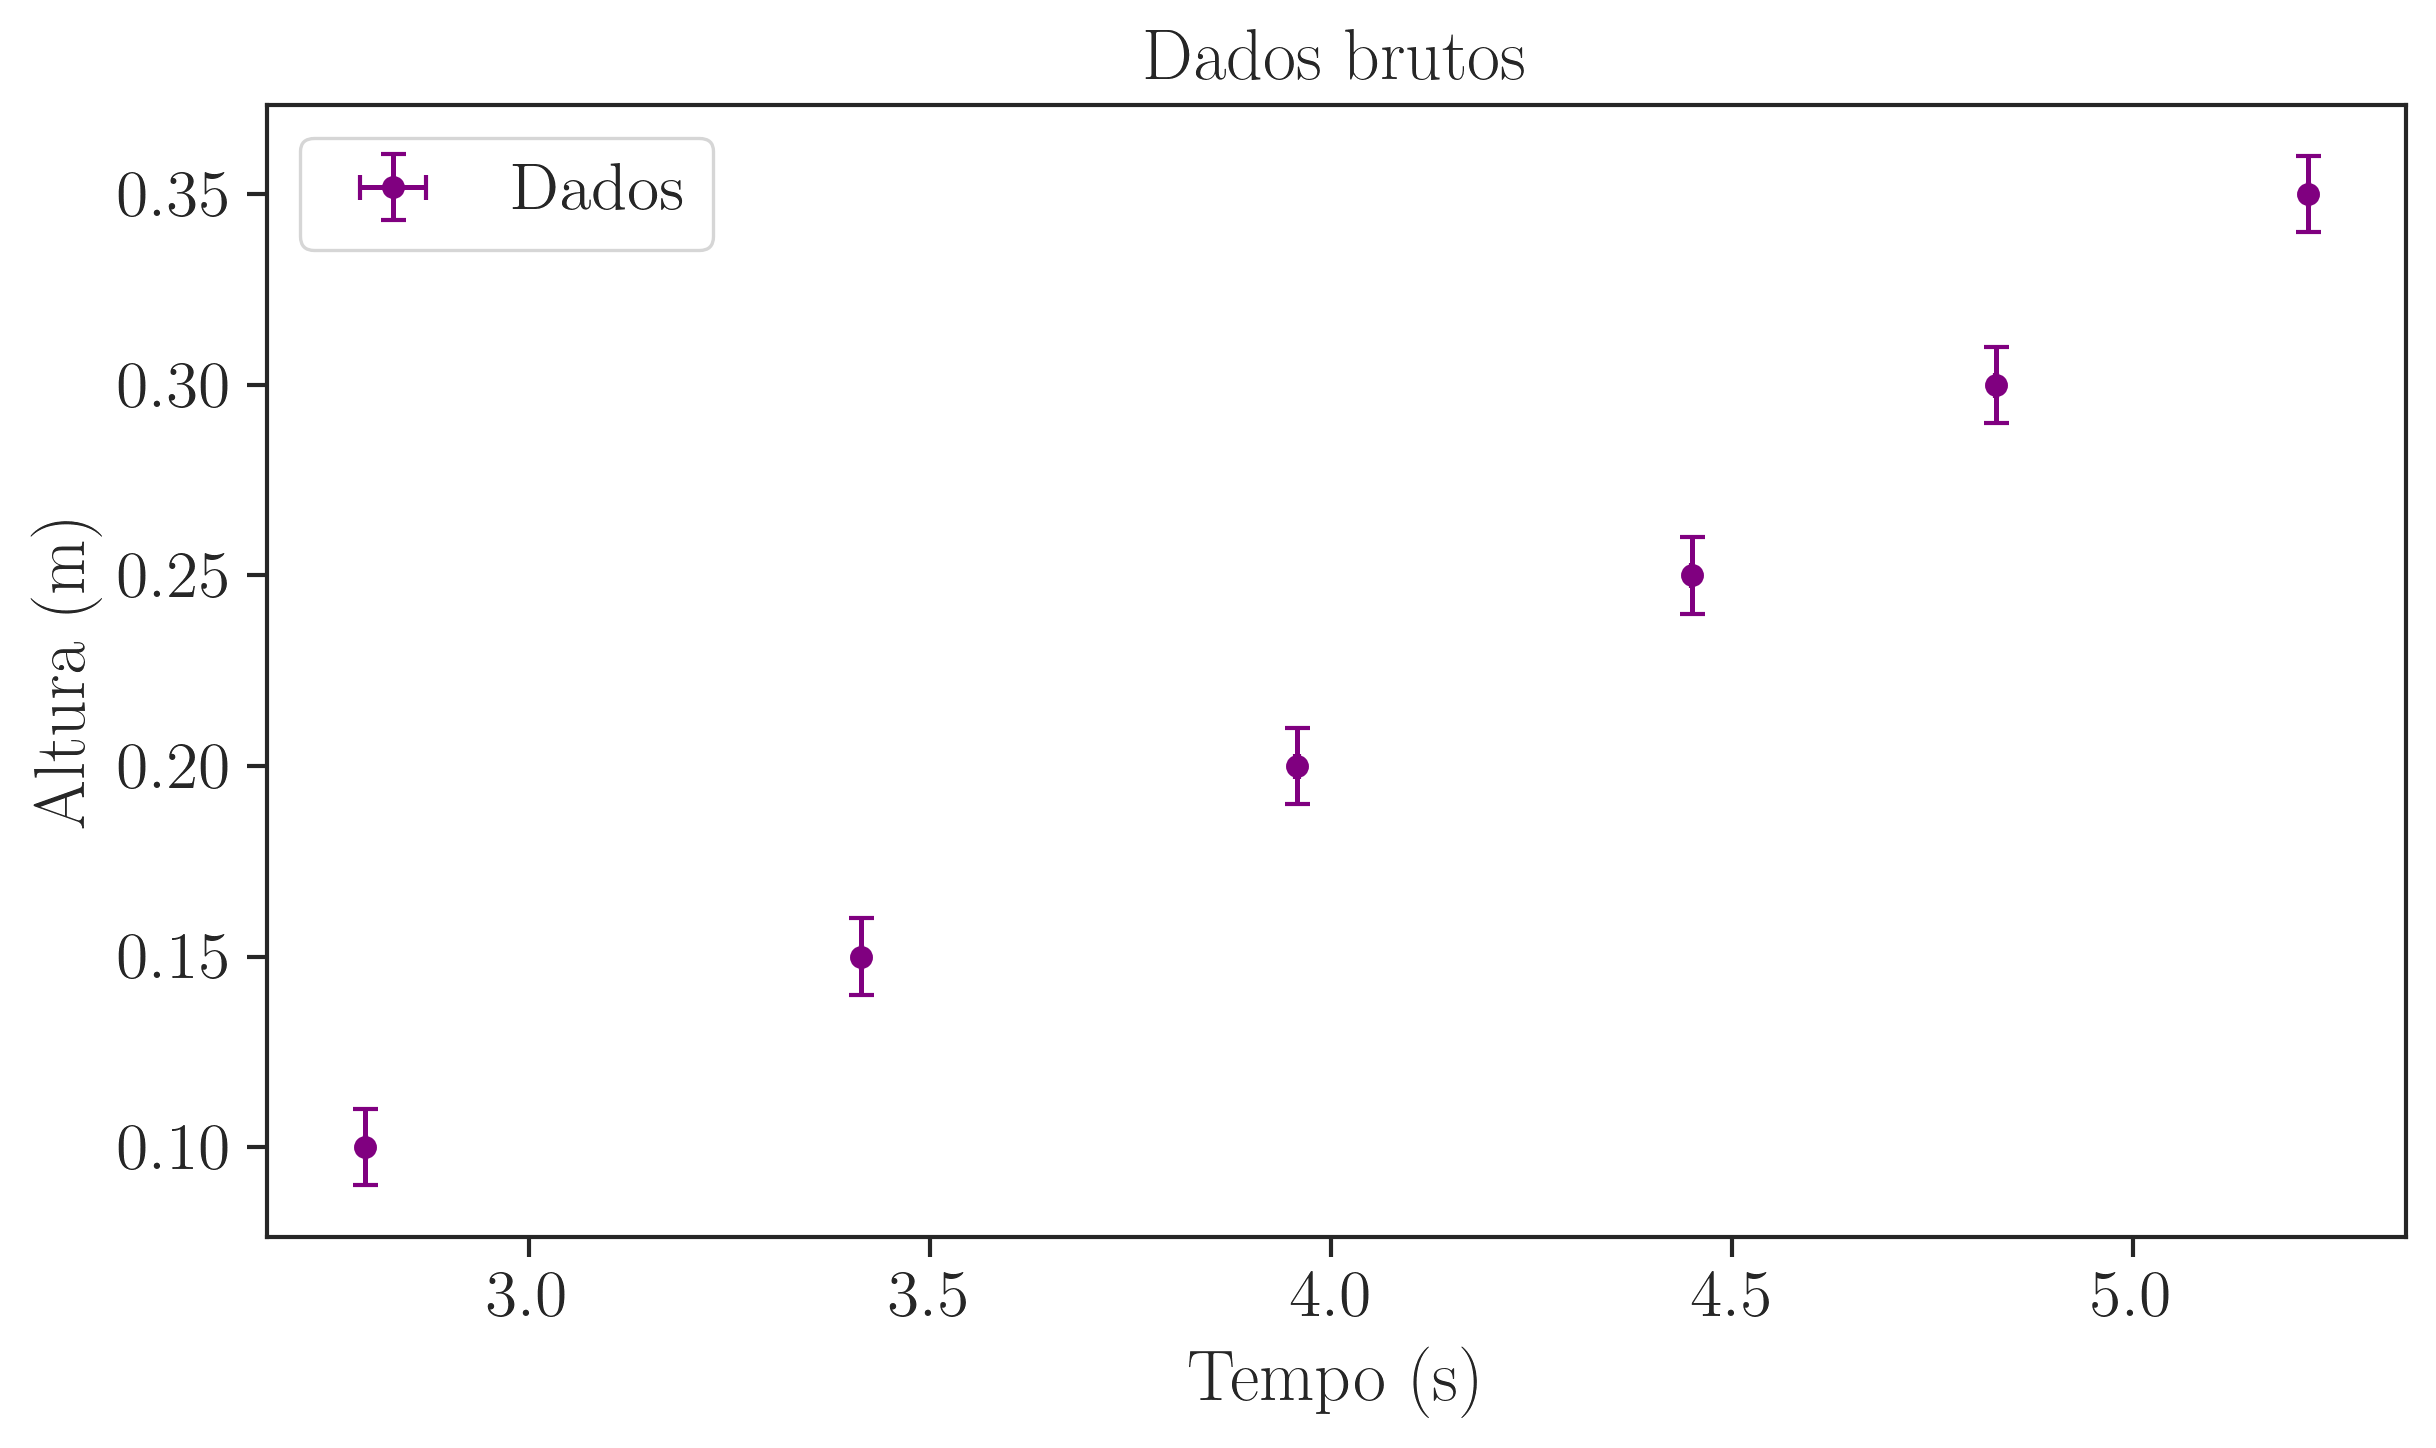

In [3]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 

plt.errorbar(time, altura, sigma_h, sigma_t, 'o', ms = 4.5, capsize=3, color = 'purple', label = 'Dados')

plt.xlabel('Tempo (s)')
plt.ylabel('Altura (m)')
plt.title('Dados brutos')
plt.legend()
plt.savefig('Graphs/RodaMaxwell/DadosBrutos.pdf')
plt.show()

# Linearização dos dados

$$\bar{t} \ \ \ \to \ \ \ \bar{t}^2$$

Para linearizar os dados vamos calcular $t^2$ e sua incerteza, a qual será dada por:

$$\sigma_{\bar{t}^2} = \bigg\vert \frac{d \bar{t}^2}{d\bar{t}}\bigg\vert \sigma_{\bar{t}} = 2 \bar{t} \sigma_{\bar{t}}$$

In [4]:
#Calculando o quadrado do tempo
time_sq = time**2

#Calculando sua incerteza
sigma_t_sq = 2*time*sigma_t

#Considerando apenas um algarismo significativo
sigma_t_sq = [float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_t_sq]

print('Tempo ao quadrado:', time_sq)
print()
print('Incerteza do tempo ao quadrado:', sigma_t_sq)

Tempo ao quadrado: [ 7.82097156 11.66154201 15.665764   19.80072004 23.319241   27.23378596]

Incerteza do tempo ao quadrado: [0.006, 0.007, 0.02, 0.007, 0.01, 0.009]


## Gráfico dos dados linearizados

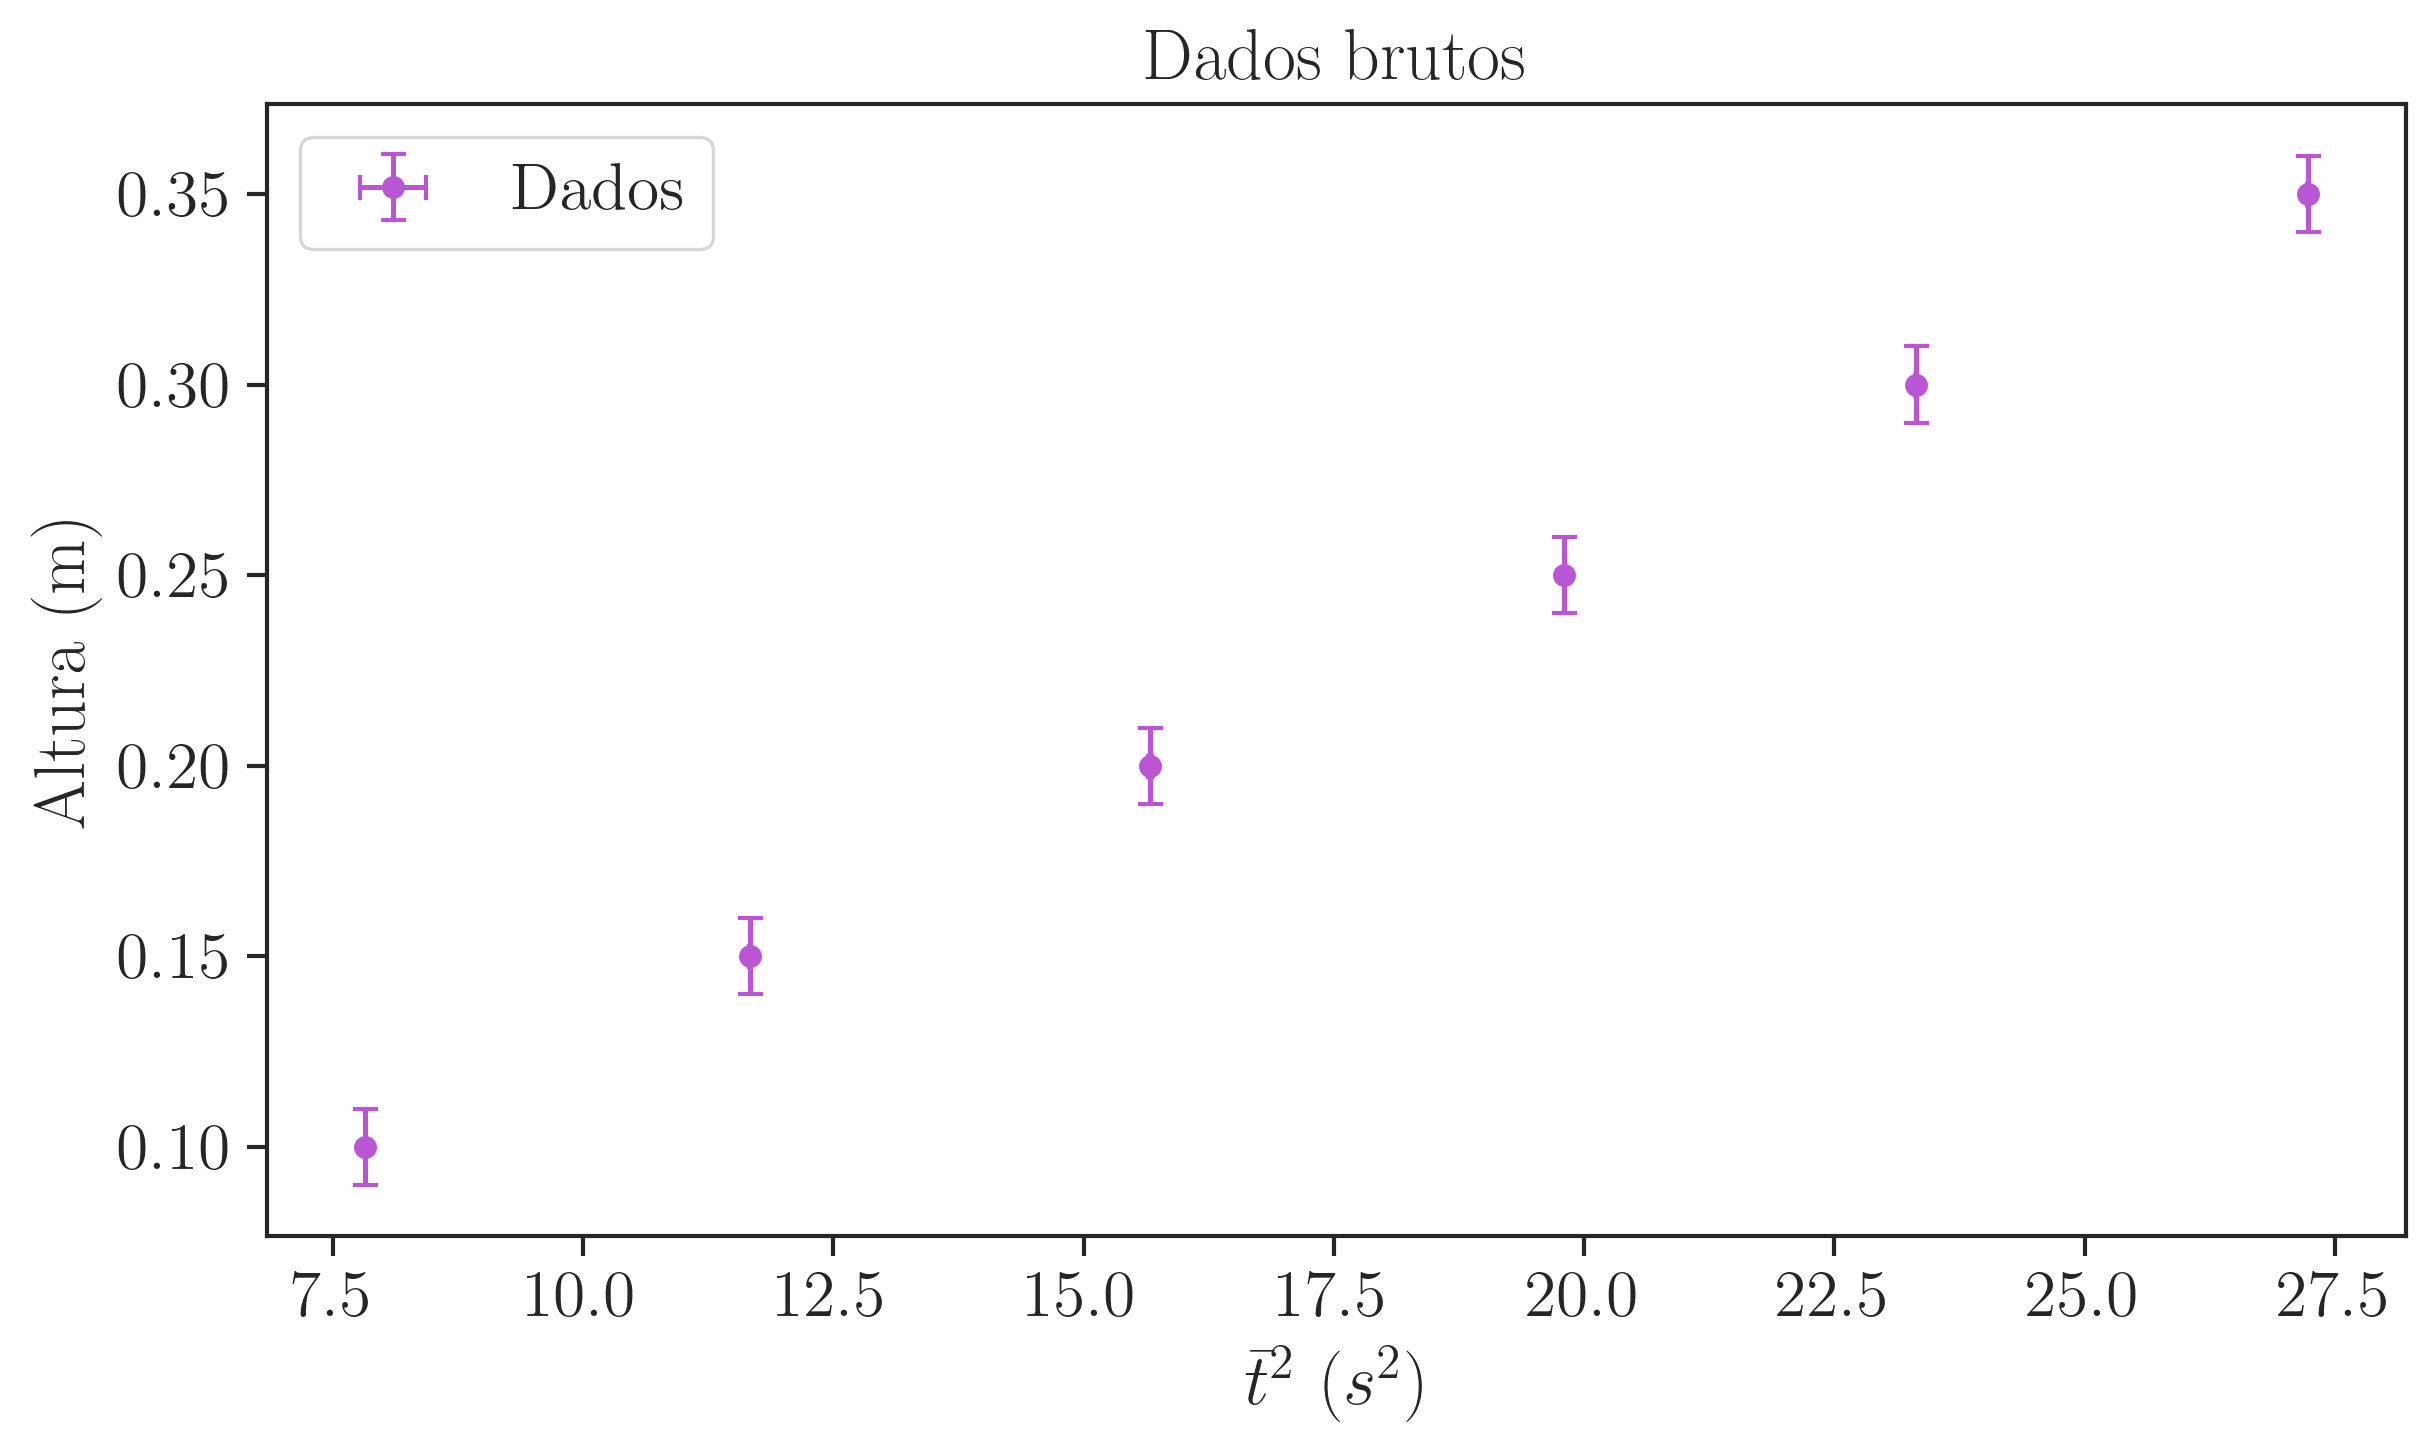

In [5]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 

plt.errorbar(time_sq, altura, sigma_h, sigma_t_sq, 'o', ms = 4.5, capsize=3, color = 'mediumorchid', label = 'Dados')

plt.xlabel(r"$\bar{t}^2$ ($s^2$)")
plt.ylabel('Altura (m)')
plt.title('Dados brutos')
plt.legend()

plt.savefig('Graphs/RodaMaxwell/DadosLin.pdf')
plt.show()

# Ajuste linear

In [6]:
fitpars, cov_pars = np.polyfit(time_sq,altura,1,w=np.power(sigma_h,-1),cov='True')
#print(fitpars, cov_pars)

coef_angular = fitpars[0]
coef_linear = fitpars[1]
sigma_angular = np.sqrt(cov_pars[0][0])
sigma_linear = np.sqrt(cov_pars[1][1])

sigma_angular = float('{:g}'.format(float('{:.1g}'.format(sigma_angular))))
sigma_linear = float('{:g}'.format(float('{:.1g}'.format(sigma_linear))))

                     
print('Coeficiente angular: %.4f +- %.4f (m/s^2)' % (coef_angular ,sigma_angular))
print('Coeficiente linear: %.3f +- %.3f (m)' %(coef_linear,sigma_linear))

Coeficiente angular: 0.0128 +- 0.0001 (m/s^2)
Coeficiente linear: -0.001 +- 0.002 (m)


$$c_a = (0.0128 \pm 0.0001) \ (m/s^2)$$

$$c_l = (-0.001 \pm 0.002) \ (m)$$

# Gráfico do ajuste linear

In [7]:
#Calulando chi^2_red
yhat = np.polyval(fitpars, time_sq)
chi_squared = np.sum(((yhat - altura)/sigma_h) ** 2)
chi2_red = chi_squared/(len(altura)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red)

chi^2_red = 0.041


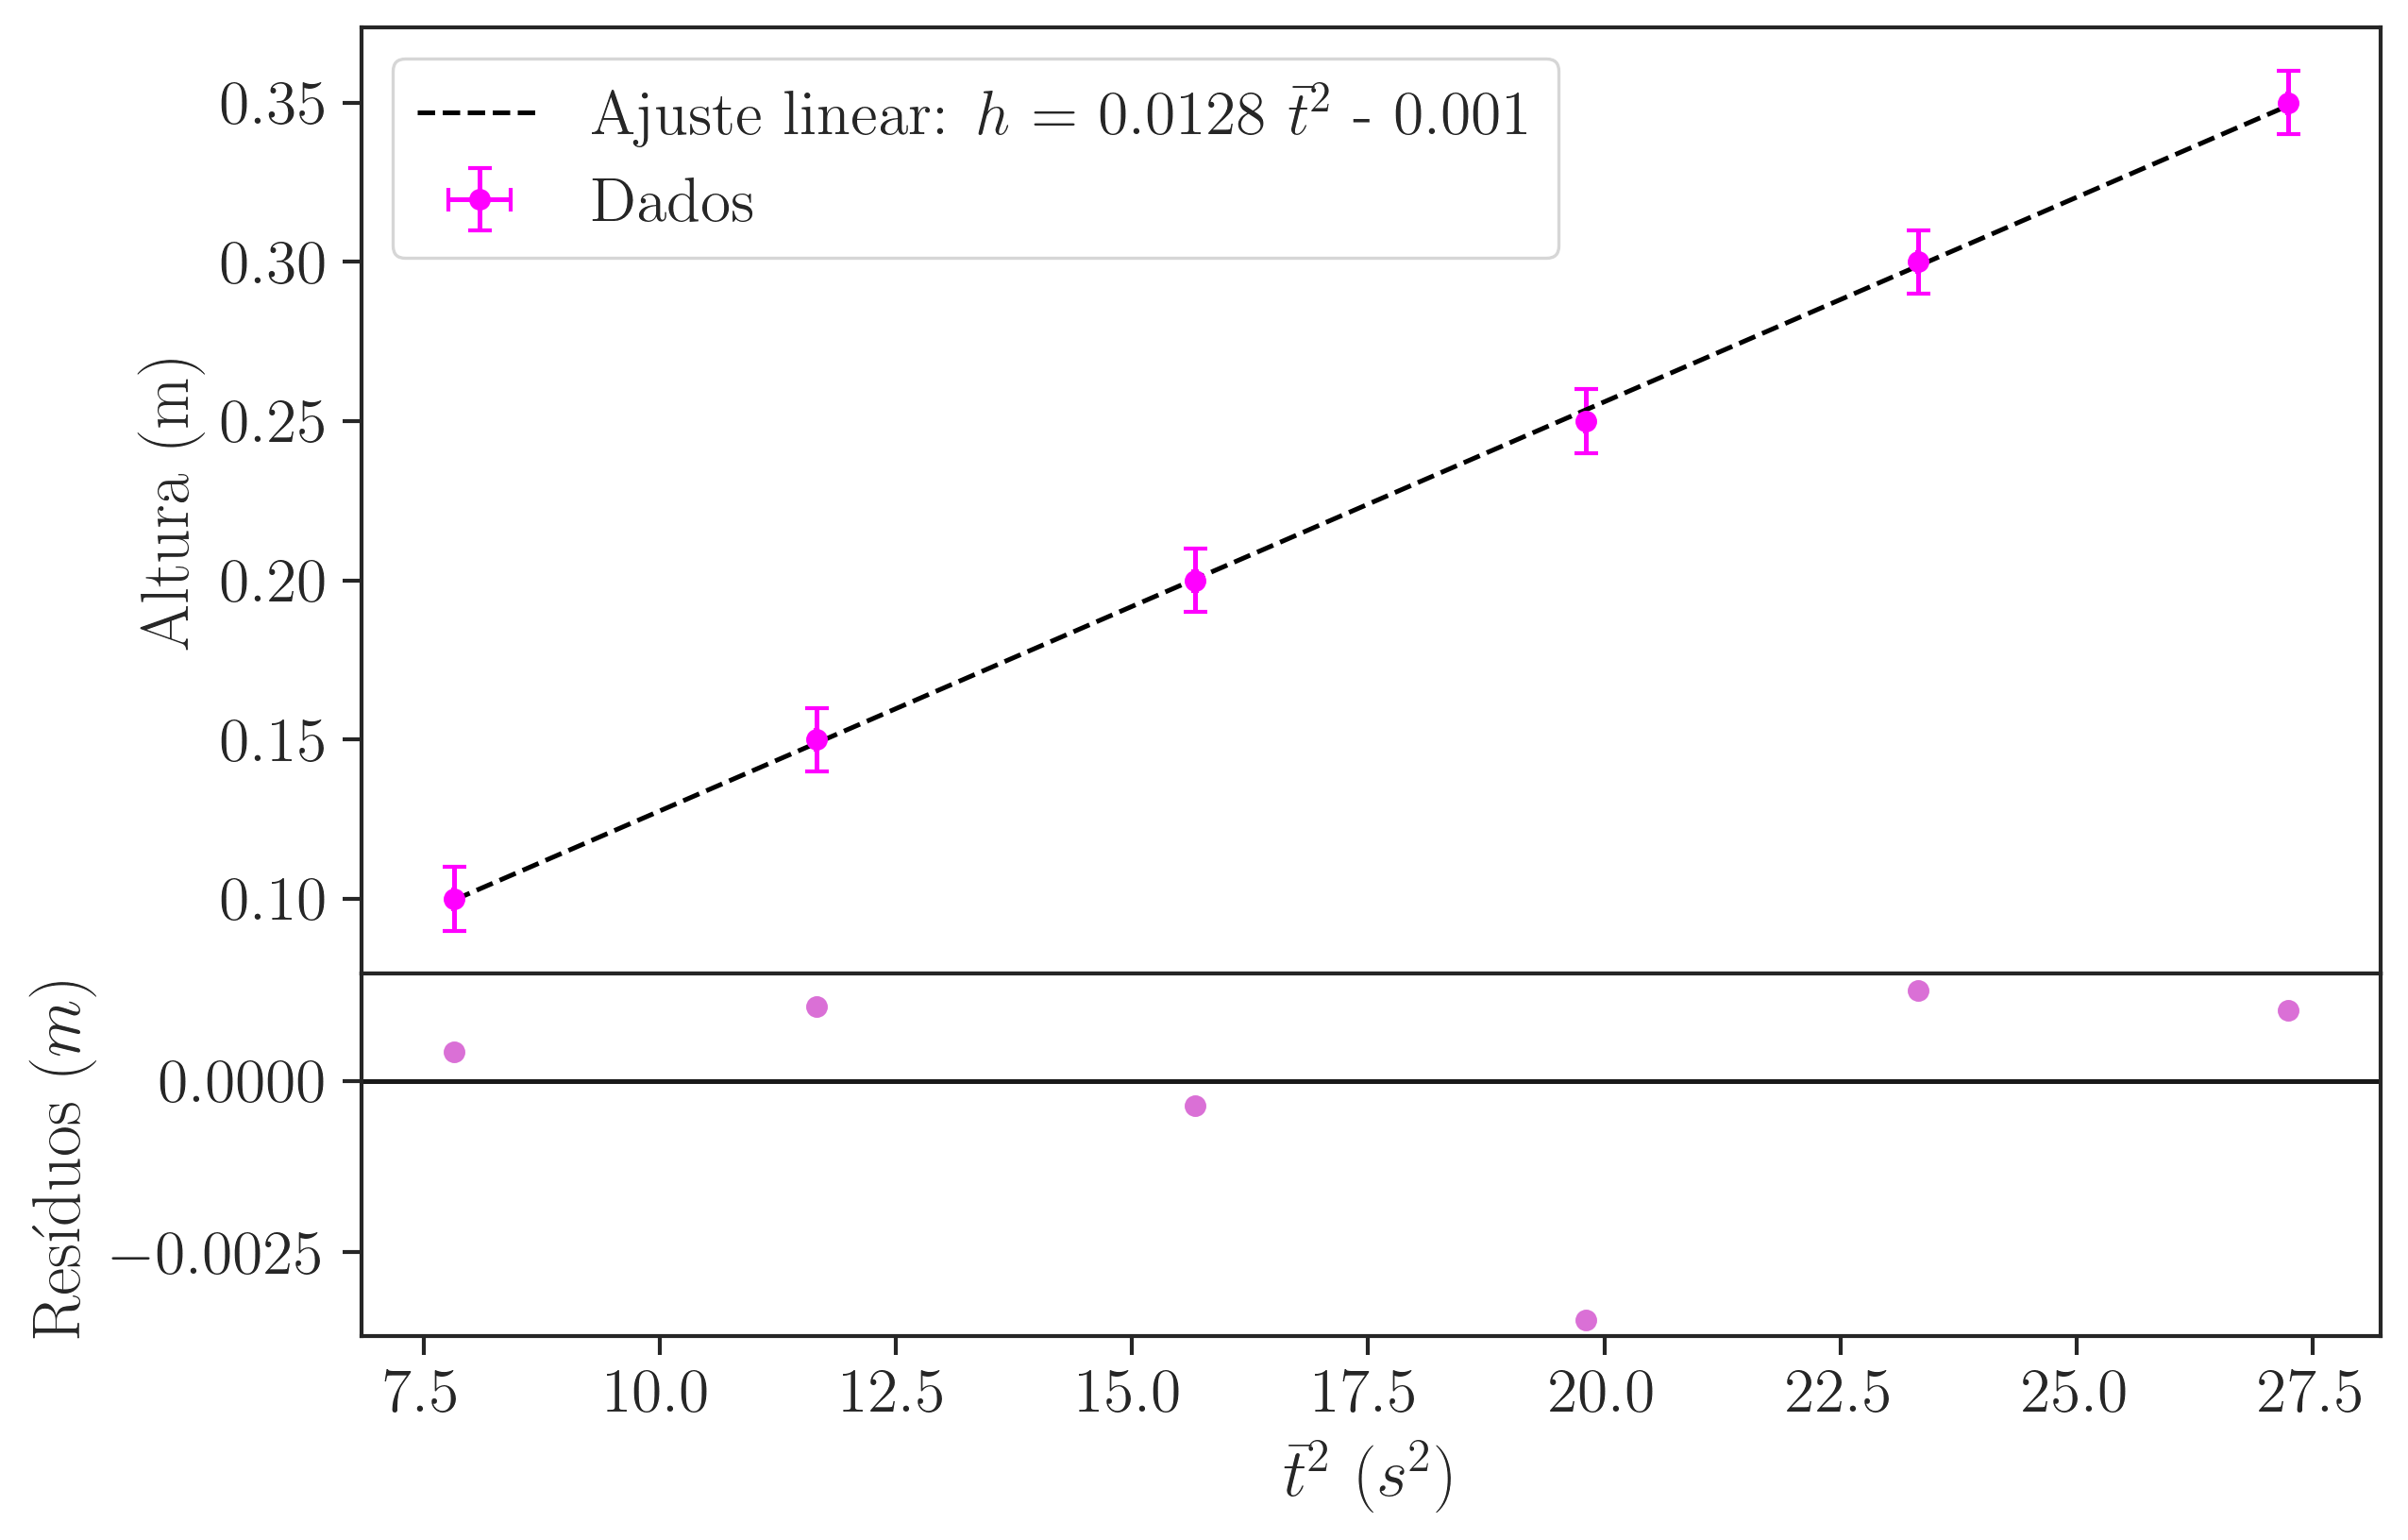

In [8]:
fig = plt.figure(figsize = [9.2,6], dpi = 300) 
gs = fig.add_gridspec(2,1, hspace=0, height_ratios=[6, 2.3])
axs = gs.subplots(sharex=True)


#Gráfico principal
axs[0] = plt.subplot(gs[0])
axs[0].errorbar(time_sq,altura, sigma_h,sigma_t_sq, 'o', ms = 4.5, capsize=3, color = 'magenta', label = 'Dados')
axs[0].plot(time_sq,(time_sq*coef_angular + coef_linear), color ='black', ls = '--',
         label = r'Ajuste linear: $h$ = %.4f $\bar{t}^2$ - %.3f' % (coef_angular,abs(coef_linear)))
axs[0].set_ylabel(r'Altura (m)')
axs[0].legend()
axs[0].set_title('')

#Gráfico de resíduos
axs[1] = plt.subplot(gs[1])
resid = (altura - yhat)
axs[1].plot(time_sq, resid, 'o',ms = 4.5,  color = 'orchid', label = 'Residuos')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].set_ylabel(r"Resíduos ($m$)")

#axs[0].plot(a,(a*0.2768), color ='black', ls = '--',
         #label = r'Ajuste linear: $F_r$ = %.3f $a$ - %.2f' % (coef_angular,abs(coef_linear)))

plt.xlabel(r'$\bar{t}^2$ ($s^2$)')


plt.savefig('Graphs/RodaMaxwell/AjusteLin.pdf')
plt.show()

$$ I_z = mr^2\left(\frac{1}{2} \frac{g}{c_a} - 1\right)$$

$$\sigma_{I_z} = mr\sqrt{\left(\frac{1}{2} \frac{rg}{c_a^2} \right)^2\sigma_{c_a}^2 + \left( \frac{g}{c_a} - 2\right)^2\sigma_{r}^2}$$

# Encontrando o momento de inércia da roda

Segundo a mecânica clássica, a equação de movimento da roda é dada por:

$$h(t) = \frac{1}{2}\frac{mg}{\left(m + \frac{I_z}{r^2}\right)} t^2$$

Comparando com o ajuste linear $h(\bar{t}) = c_a \bar{t}^2 + c_l$, nós vemos que:

$$c_a = \frac{1}{2}\frac{mg}{\left(m + \frac{I_z}{r^2}\right)}$$

$$c_l = 0 $$

Para obtermos uma estimativa do momento de inércia, podemos isolá-lo na equação do coeficiente angular:

$$m + \frac{I_z}{r^2} = \frac{1}{2} \frac{mg}{c_a}$$
$$ \frac{I_z}{r^2} = \frac{1}{2} \frac{mg}{c_a} - m$$

$$ I_z = mr^2\left(\frac{1}{2} \frac{g}{c_a} - 1\right)$$

A incerteza associada ao momento de inércia pode ser obtida propagando o erro do coeficiente angular e do raio da seguinte forma:

$$\sigma_{I_z} = \sqrt{\left(\frac{\partial I_z}{\partial c_a}\right)^2\sigma_{c_a}^2 + \left(\frac{\partial I_z}{\partial r}\right)^2\sigma_{r}^2}$$

$$\sigma_{I_z} = \sqrt{\left(\frac{\partial }{\partial c_a}mr^2\left(\frac{1}{2} \frac{g}{c_a} - 1\right)\right)^2\sigma_{c_a}^2 + \left(\frac{\partial}{\partial r} mr^2\left(\frac{1}{2} \frac{g}{c_a} - 1\right)\right)^2\sigma_{r}^2}$$

$$\sigma_{I_z} = \sqrt{\left(-\frac{1}{2} \frac{mr^2g}{c_a^2} \right)^2\sigma_{c_a}^2 + \left( 2mr\left(\frac{1}{2} \frac{g}{c_a} - 1\right)\right)^2\sigma_{r}^2}$$

$$\sigma_{I_z} = mr\sqrt{\left(\frac{1}{2} \frac{rg}{c_a^2} \right)^2\sigma_{c_a}^2 + \left( \frac{g}{c_a} - 2\right)^2\sigma_{r}^2}$$

No caso da medida ser realizada com um paquímetro, a incerteza do raio é muito pequena, de modo que:

$$\sigma_{I_z} = \frac{1}{2}mr^2 \frac{g}{c_a^2}\sigma_{c_a}$$

In [48]:
#Dados da roda
m = 0.436 #kg
r_roda = 12.950/2 * 1e-2 #m
r = 0.505/2 * 1e-2 #m
sigma_r = 5e-6 #m
g = 9.81 #m/s^2

#Calculando I_z:
i_z = m * r**2 * (g/(2*coef_angular) - 1)

#Calculando a incerteza de I_z
sigma_i_z = m * r * np.sqrt((r*g*sigma_angular/(2 * (coef_angular**2)))**2 + ((g/coef_angular - 2)*sigma_r)**2)
#sigma_i_z = 1/2 * m * r**2 * (g/(coef_angular**2)) * sigma_angular
sigma_i_z = float('{:g}'.format(float('{:.1g}'.format(sigma_i_z))))

#print("Momento de inércia = (%.2f +- %.2f) (kg m^2)" % (i_z,sigma_i_z))
print("Momento de inércia = (%.5f +- %.5f) (kg m^2)" % (i_z,sigma_i_z))

Momento de inércia = (0.00106 +- 0.00001) (kg m^2)


In [ ]:
print()

In [49]:
print(m*r_roda**2)
print(0.5*m*r_roda**2)

0.0018279572500000001
0.0009139786250000001


$$I_z = (1.06 \pm 0.01)\times 10^{-3} \ (kg m^2) $$

$$0.0018  \ (kg m^2)$$

$$0.0009   \ (kg m^2)$$

$$E_p = 0$$

# A velocidade da roda

Nós vimos que os dados de altura por tempo ao quadrado apresentam uma relação linear. Portanto, para encontrarmos a velocidade linear da roda, basta derivarmos a equação obtida através do ajuste:

$$v(\bar{t}) = \frac{d h(\bar{t})}{d \bar{t}}$$

$$v(\bar{t}) = \frac{d }{d \bar{t}} (c_a \bar{t}^2 + c_l)$$

$$v(\bar{t}) =2c_a\bar{t}$$

A incerteza associada a velocidade pode ser obtida através da propagação do erro do coefciente angular e do tempo médio da seguinte forma:

$$\sigma_v = \sqrt{\left(\frac{\partial v(\bar{t})}{\partial c_a}\right)^2\sigma_{c_a}^2 + \left(\frac{\partial v(\bar{t})}{\partial \bar{t}}\right)^2\sigma_{\bar{t}}^2}$$

$$\sigma_v = \sqrt{\left(\frac{\partial 2c_a\bar{t}}{\partial c_a}\right)^2\sigma_{c_a}^2 + \left(\frac{\partial 2c_a\bar{t}}{\partial \bar{t}}\right)^2\sigma_{\bar{t}}^2}$$


$$\sigma_v = \sqrt{\left(2 \bar{t}\right)^2\sigma_{c_a}^2 + \left( 2c_a\right)^2\sigma_{\bar{t}}^2}$$

$$\sigma_v = 2c_a\bar{t}\sqrt{\left(\frac{\sigma_{c_a}}{c_a}\right)^2 + \left( \frac{\sigma_{\bar{t}}}{\bar{t}}\right)^2}$$

$$v(\bar{t}) = \frac{d h(\bar{t})}{d \bar{t}} = 2c_a\bar{t}$$

$$\sigma_v = 2c_a\bar{t}\sqrt{\left(\frac{\sigma_{c_a}}{c_a}\right)^2 + \left( \frac{\sigma_{\bar{t}}}{\bar{t}}\right)^2}$$

In [11]:
#Calculando a velocidade
v = 2*coef_angular*time

#Calculando a incerteza da velocidade linear
sigma_v = v * np.sqrt((sigma_angular/coef_angular)**2 + (sigma_t/time)**2)
sigma_v = np.array([float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_v])

print('Velocidade linear:', v)
print()
print('Incerteza da velocidade linear:', sigma_v)

Velocidade linear: [0.07185343 0.0877395  0.10169344 0.11432933 0.12407216 0.13408221]

Incerteza da velocidade linear: [0.0006 0.0007 0.0008 0.0009 0.001  0.001 ]


#  A velocidade angular da roda

Nós sabemos que $\mathbf{v} = \mathbf{\omega} \times \mathbf{r}$, mas esta relação pode ser invertida da seguinte forma:

$$\mathbf{r} \times \mathbf{v} = \mathbf{r} \times (\mathbf{\omega} \times \mathbf{r})$$

$$\mathbf{r} \times \mathbf{v} = \mathbf{\omega} (\mathbf{r}\cdot \mathbf{r}) - \mathbf{r} (\mathbf{\omega}\cdot\mathbf{r})$$

Como $\mathbf{\omega}$ é perpendicular a $\mathbf{r}$, então $(\mathbf{\omega}\cdot\mathbf{r}) = 0$ Desta forma:

$$r^2\mathbf{\omega} = \mathbf{r} \times \mathbf{v}$$

$$ \mathbf{\omega} =\frac{\mathbf{r} \times \mathbf{v}}{r^2} $$

Neste caso, a velocidade linear sempre será perpendicular ao vetor $\mathbf{r}$. Consequentemente:

$$\omega = \frac{v}{r}$$


A incerteza da velocidade angular pode ser obtida através da propagação do erro da velocidade linear da seguinte forma:

$$\sigma_{\omega} = \bigg\vert\frac{d \omega}{dv}\bigg\vert\sigma_{v}$$

$$\sigma_{\omega} = \bigg\vert\frac{d \frac{v}{r}}{dv}\bigg\vert\sigma_{v}$$

$$\sigma_{\omega} = \frac{1}{r}\sigma_{v}$$

$$\omega = \frac{v}{R}$$

$$\sigma_{\omega} = \frac{1}{R}\sigma_{v}$$

In [12]:
#Calculando a velocidade angular
omega = v/r

#Calculando a incerteza da velocidade angular
sigma_omega = sigma_v/r
sigma_omega = [float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_omega]

print('Velocidade angular:', omega)
print()
print('Incerteza da velocidade angular:', sigma_omega)

Velocidade angular: [28.45680393 34.74831572 40.27462989 45.2789409  49.13749059 53.10186547]

Incerteza da velocidade angular: [0.2, 0.3, 0.3, 0.4, 0.4, 0.4]


# Os tipos de energia na roda de Maxwell


## A energia potencial gravitacional

Escolhendo o zero do potencial no ponto em que a roda está em $h_0 = 35cm$:

$$E_p = mg(h_0 - h)$$


Propagando o erro das alturas:

$$\sigma_{E_p} = \sqrt{\left(\frac{\partial E_p}{\partial h}\right)^2 \sigma_h^2 + \left(\frac{\partial E_p}{\partial h_0}\right)^2 \sigma_{h_0}^2}$$

$$\sigma_{E_p} = \sqrt{\left(-mg\right)^2 \sigma_h^2 + \left(mg\right)^2 \sigma_{h_0}^2}$$

$$\sigma_{E_p} = mg\sqrt{ \sigma_h^2 +  \sigma_{h_0}^2}$$


Como $\sigma_h = \sigma_{h_0}$:

$$\sigma_{E_p} = mg\sigma_h\sqrt{2}$$

## A energia cinética translacional

$$K_T = \frac{1}{2}mv^2$$

Propagando o erro da velocidade:

$$\sigma_{K_T} = \bigg\vert\frac{d K_T}{dv}\bigg\vert\sigma_{v} = mv\sigma_v$$


## A energia cinética rotacional

$$K_R = \frac{1}{2} I_z \omega^2$$

Propagando o erro da velocidade angular e do momento de inércia:

$$\sigma_{K_R} = \sqrt{\left(\frac{\partial K_R}{\partial \omega}\right)^2\sigma_{omega}^2 + \left(\frac{\partial K_R}{\partial I_z}\right)^2\sigma_{I_z}^2 }$$

$$\sigma_{K_R} = \sqrt{\left(I_z\omega\sigma_{omega}\right)^2\sigma_{omega}^2 + \left(\frac{1}{2}\omega^2\right)^2\sigma_{I_z}^2 }$$

$$\sigma_{K_R} = I_z \omega^2\sqrt{\left(\frac{\sigma_{omega}}{\omega}\right)^2 + \left(\frac{\sigma_{I_z}}{2I_z}\right)^2 }$$


# A energia mecânica total

$$E = E_p + K_T + K_R$$

Propagando a incerteza de cada energia:

$$\sigma_E = \sqrt{\left(\frac{\partial E}{\partial E_p}\right)^2\sigma_{E_p}^2 + \left(\frac{\partial E}{\partial K_T}\right)^2\sigma_{K_T}^2 + \left(\frac{\partial E}{\partial K_R}\right)^2\sigma_{K_R}^2}$$


$$\sigma_E = \sqrt{\sigma_{E_p}^2 + \sigma_{K_T}^2 + \sigma_{K_R}^2}$$


In [13]:
#Calculando a energia potencial gravitacional:
E_p = -m*g*(altura - 35e-2)

#Calculando a incerteza da energia potencial:
sigma_E_p = m*g*sigma_h*np.sqrt(2)
sigma_E_p = np.array([float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_E_p])

#Calculando a energia cinética translacional:
K_T = 1/2 * m * v**2

#Calculando a incerteza da energia cinética translacional:
sigma_K_T = m * v * sigma_v
sigma_K_T = np.array([float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_K_T])

#Calculando a energia cinética rotacional:
K_R = 1/2 * i_z * omega**2

#Calculando a incerteza da energia cinética rotacional:
sigma_K_R = i_z * omega**2 * np.sqrt((sigma_omega/omega)**2 + (sigma_i_z/(2*i_z)))
sigma_K_R = np.array([float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_K_R])

#Calculando a energia mecância total:
E = E_p + K_T + K_R

#Calculando a incerteza da energia mecânica total:
sigma_E = np.sqrt(sigma_E_p**2 + sigma_K_T**2 + sigma_K_R**2)

# Gráfico das energias por posição:


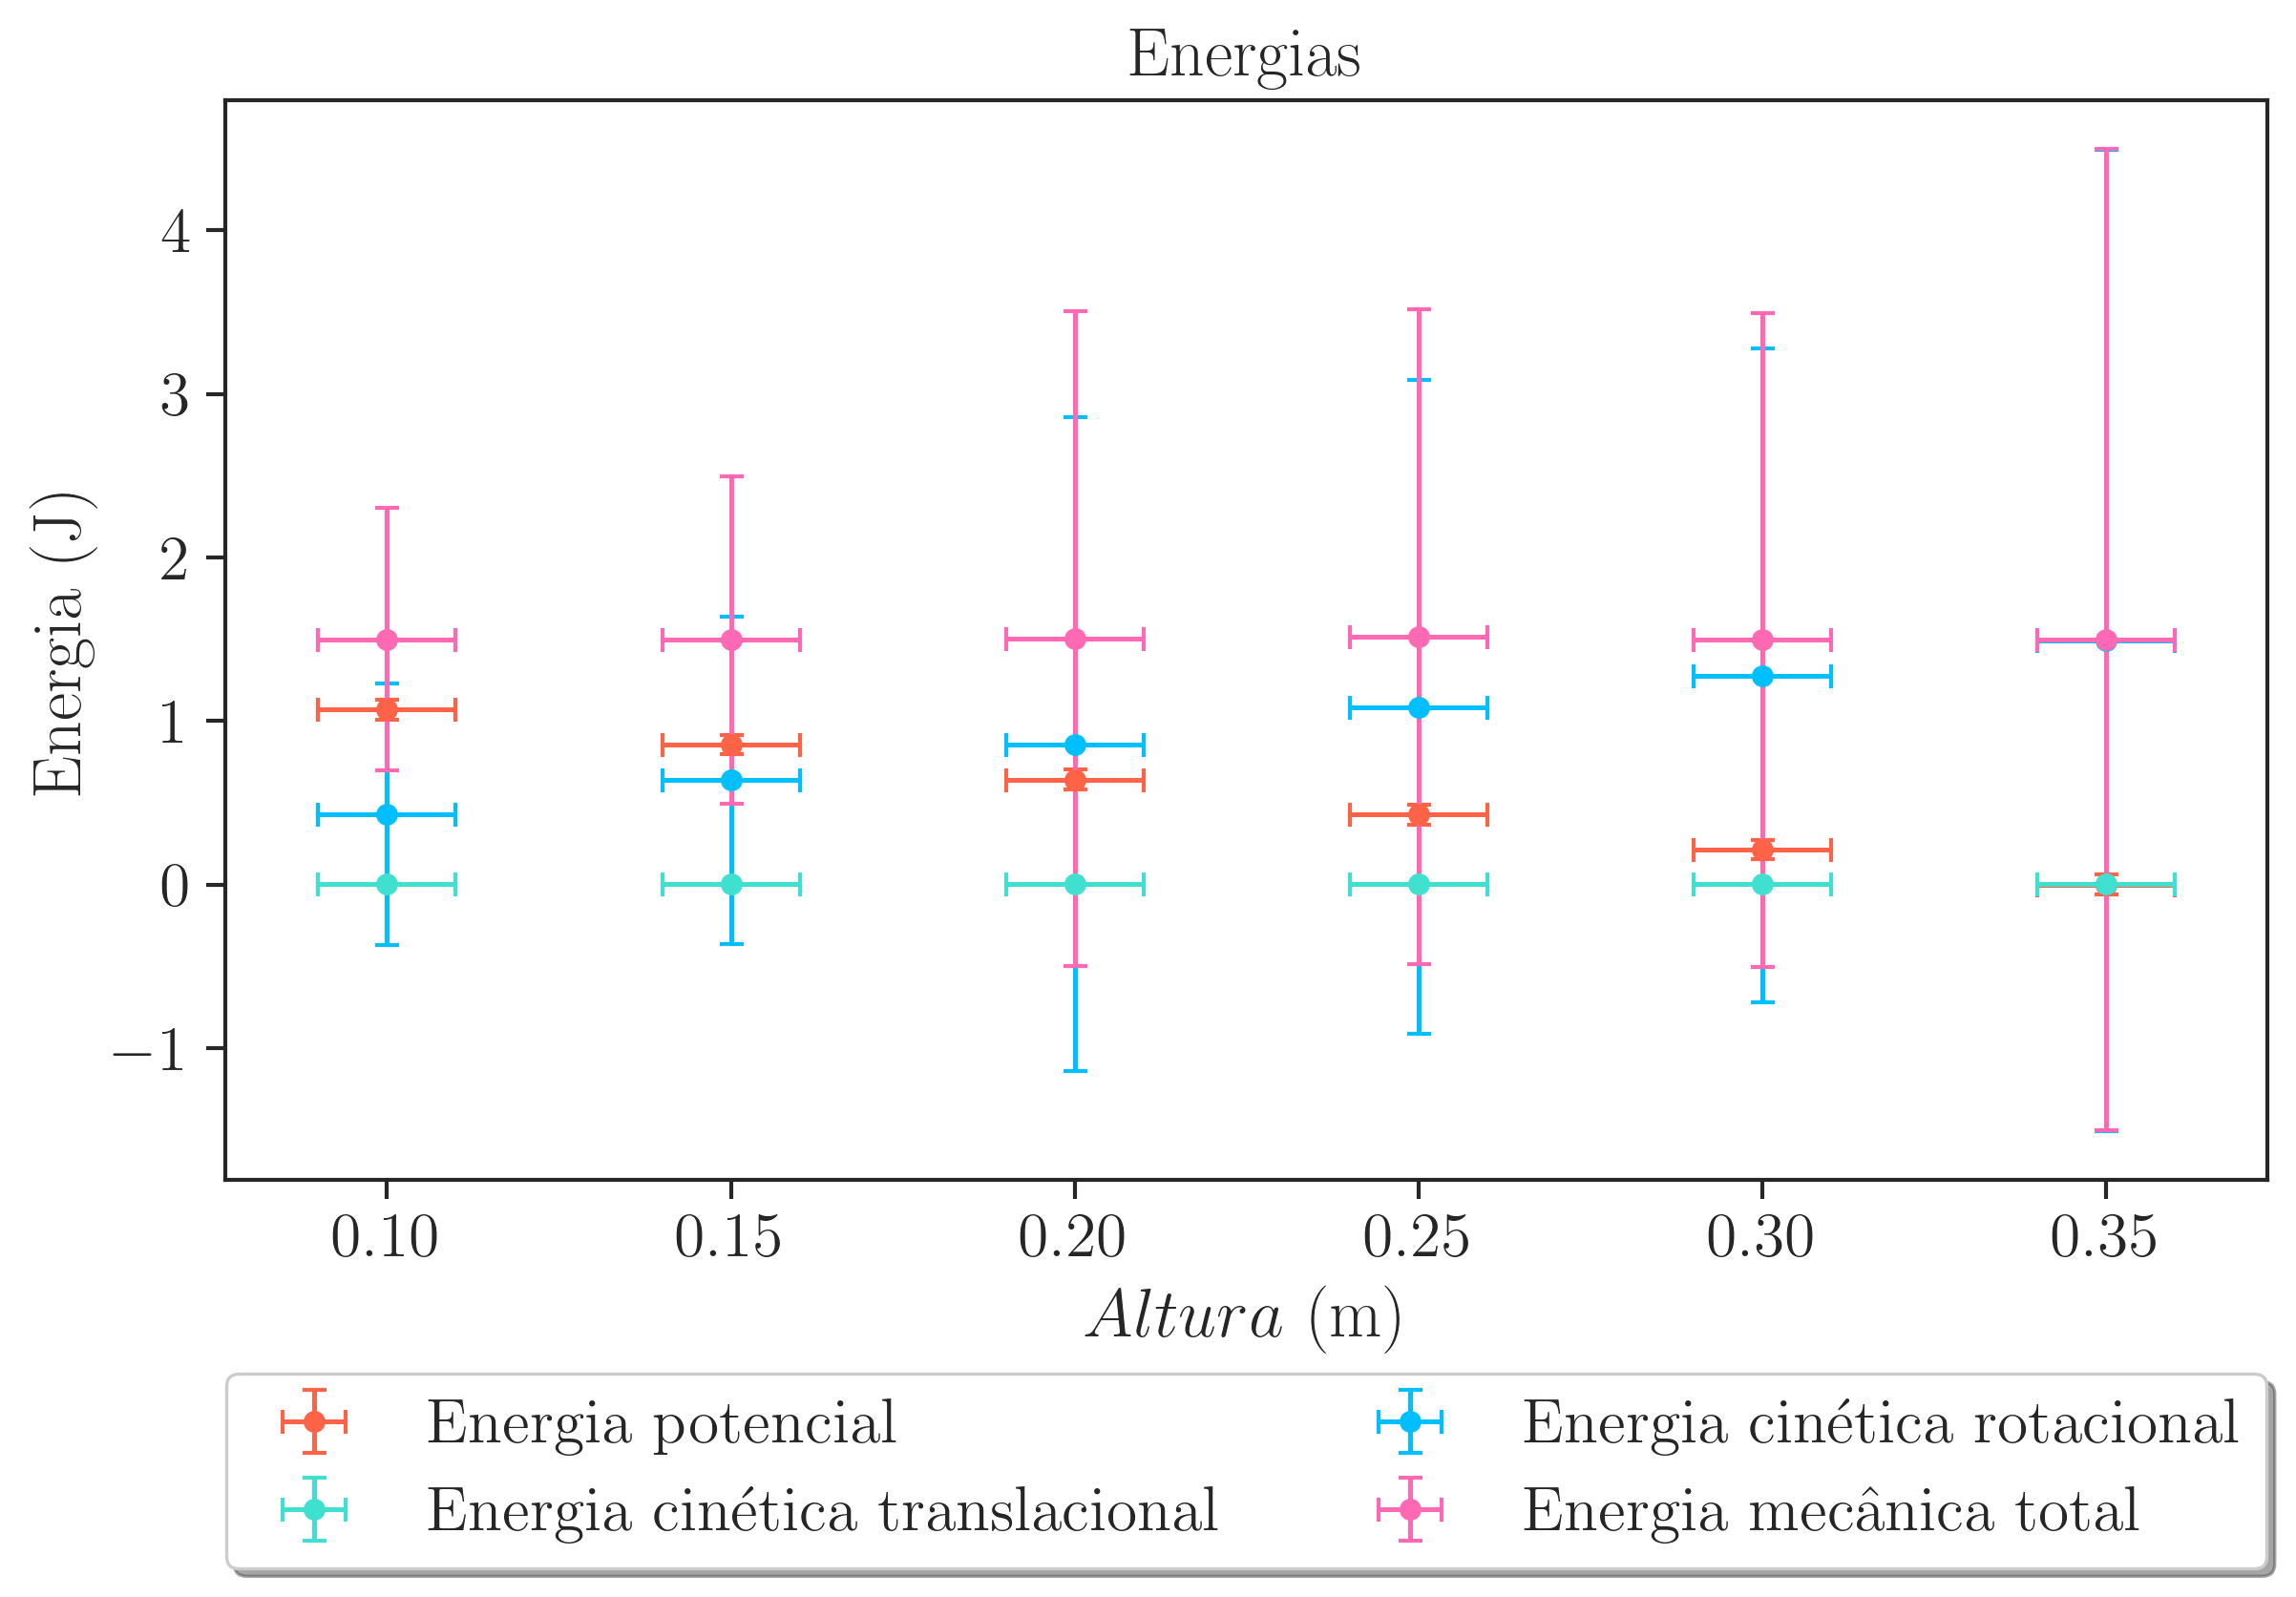

In [50]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
ax = plt.subplot(111)

ax.errorbar(altura, E_p, sigma_E_p, sigma_h, 'o', ms = 4.5, capsize=3, color = 'tomato', label = 'Energia potencial')
ax.errorbar(altura, K_T, sigma_K_T, sigma_h, 'o', ms = 4.5, capsize=3, color = 'turquoise',
             label = 'Energia cinética translacional')
ax.errorbar(altura, K_R, sigma_K_R, sigma_h, 'o', ms = 4.5, capsize=3, color = 'deepskyblue',
             label = 'Energia cinética rotacional')

ax.errorbar(altura, E, sigma_E, sigma_h, 'o', ms = 4.5, capsize=3, color = 'hotpink',
             label = 'Energia mecânica total')

plt.xlabel(r"$Altura$ (m)")
plt.ylabel('Energia (J)')
plt.title('Energias')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)


plt.savefig('Graphs/RodaMaxwell/Energias.pdf')
plt.show()

# Gráfico da energia potencial gravitacional

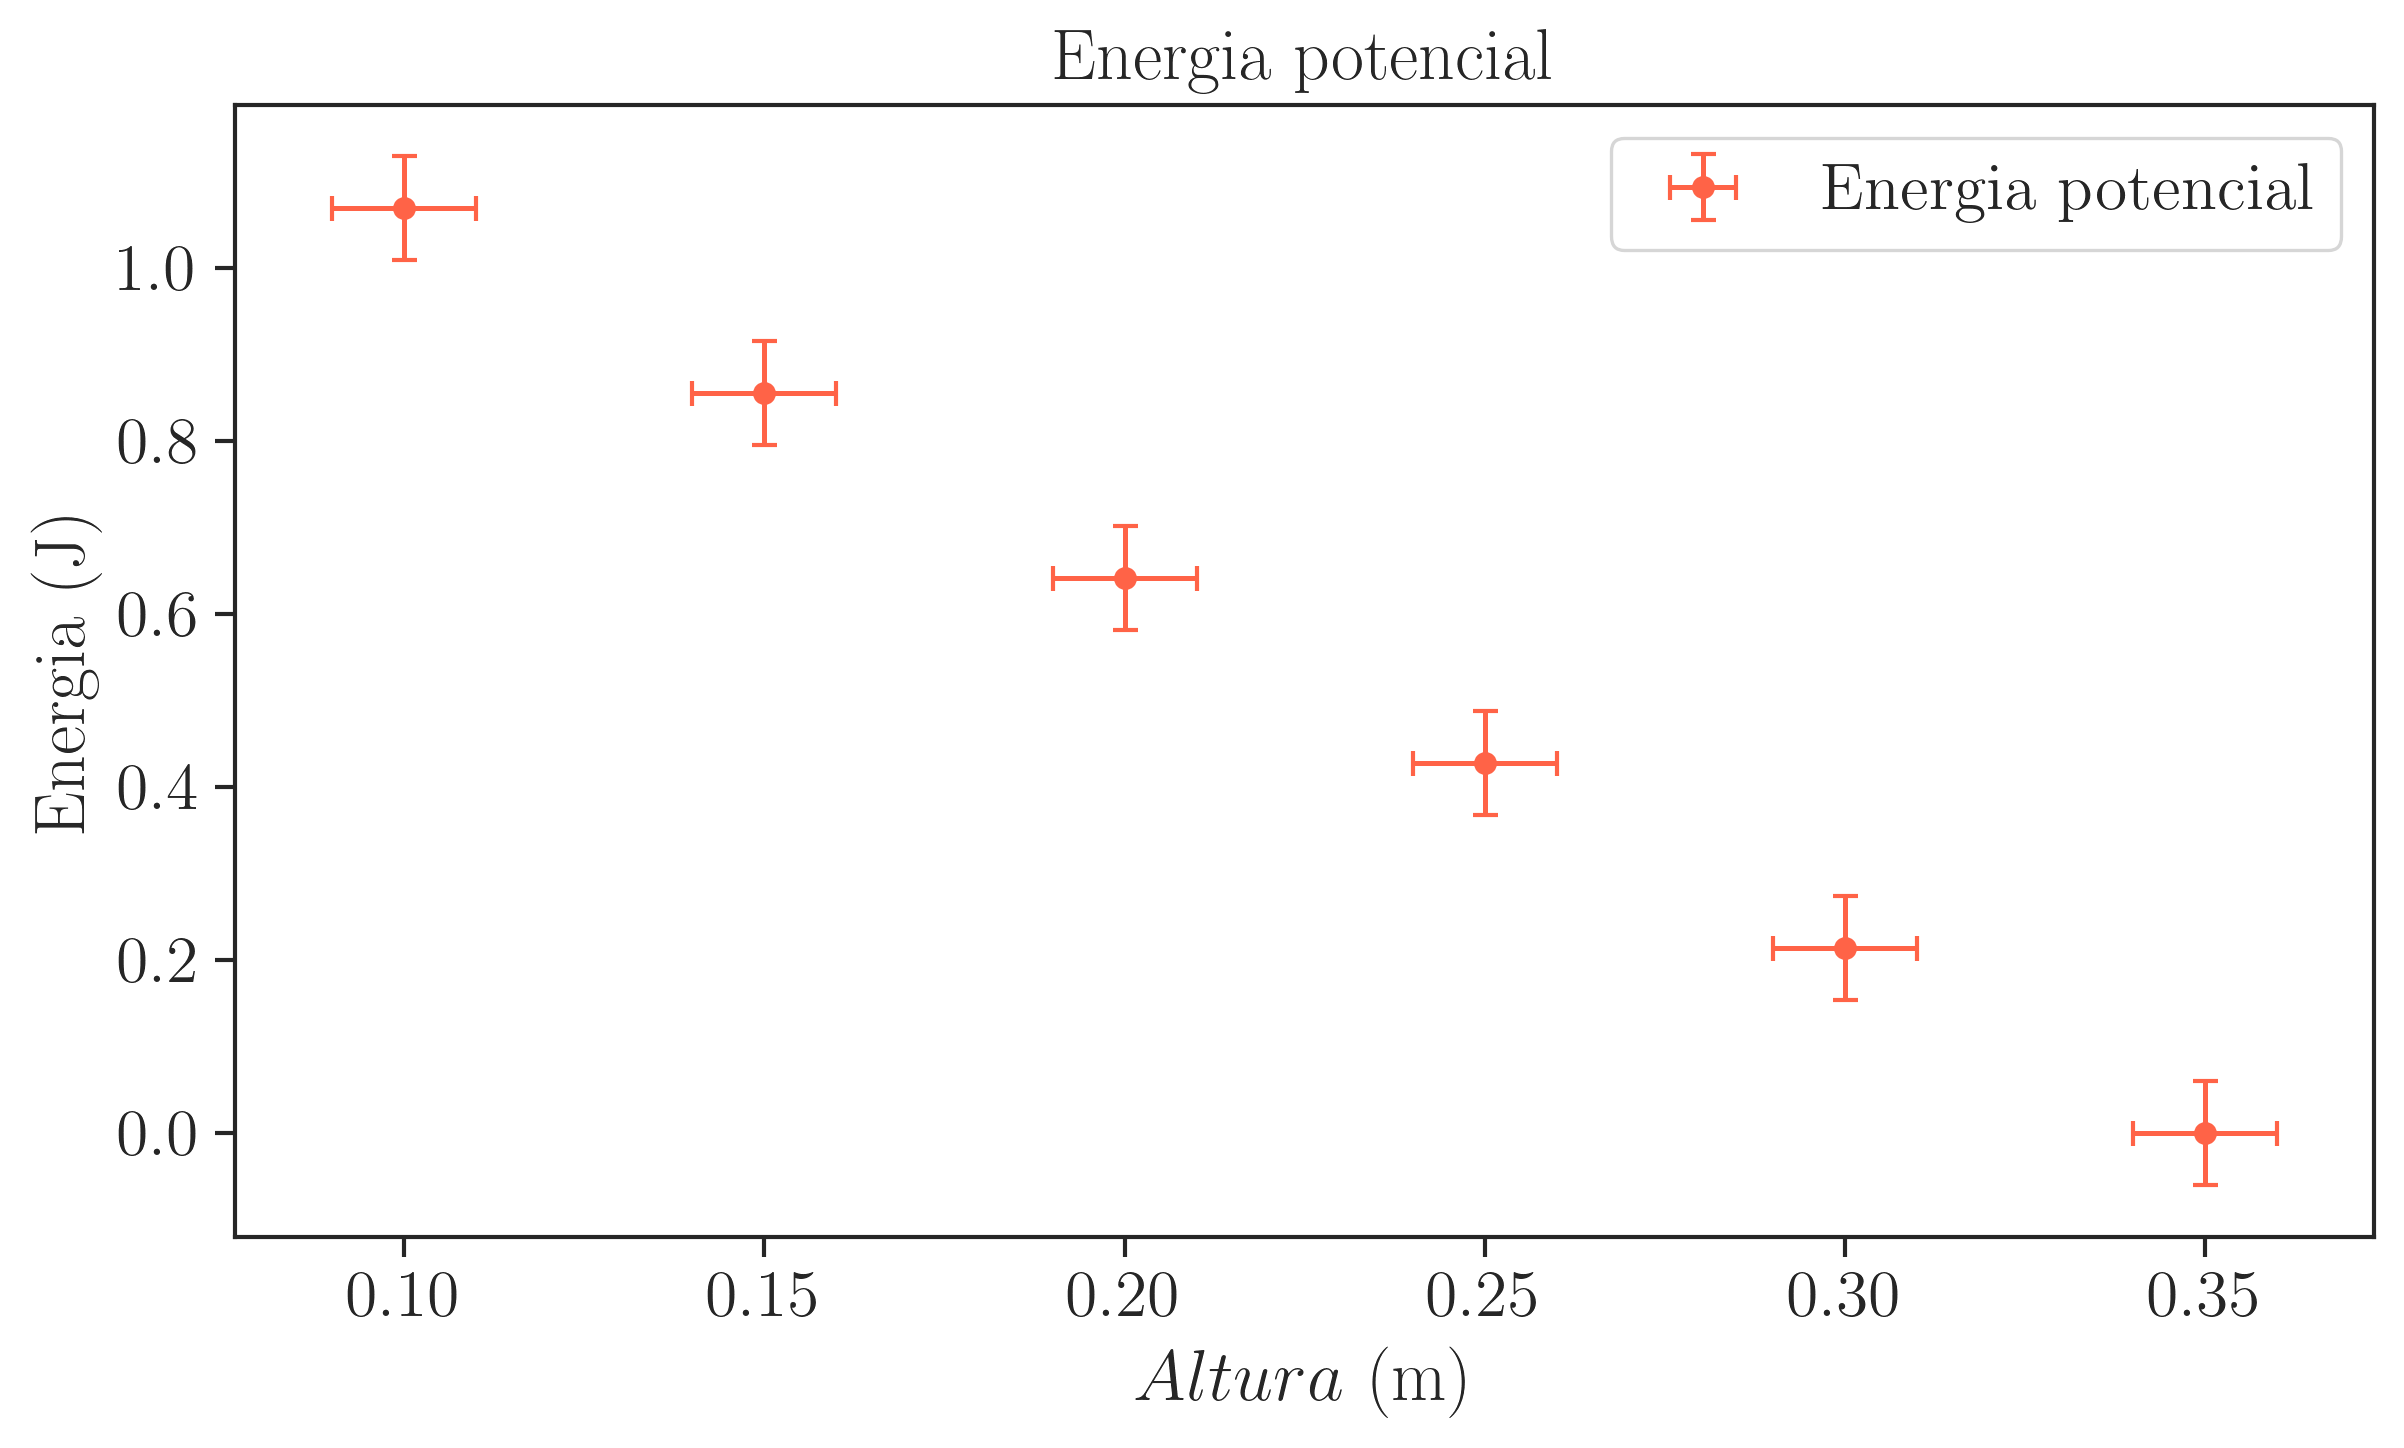

In [15]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
ax = plt.subplot(111)

ax.errorbar(altura, E_p, sigma_E_p, sigma_h, 'o', ms = 4.5, capsize=3, color = 'tomato', label = 'Energia potencial')


plt.xlabel(r"$Altura$ (m)")
plt.ylabel('Energia (J)')
plt.title('Energia potencial')
plt.legend()

plt.savefig('Graphs/RodaMaxwell/EnergiaPot.pdf')
plt.show()

# Gráfico da energia cinética translacional

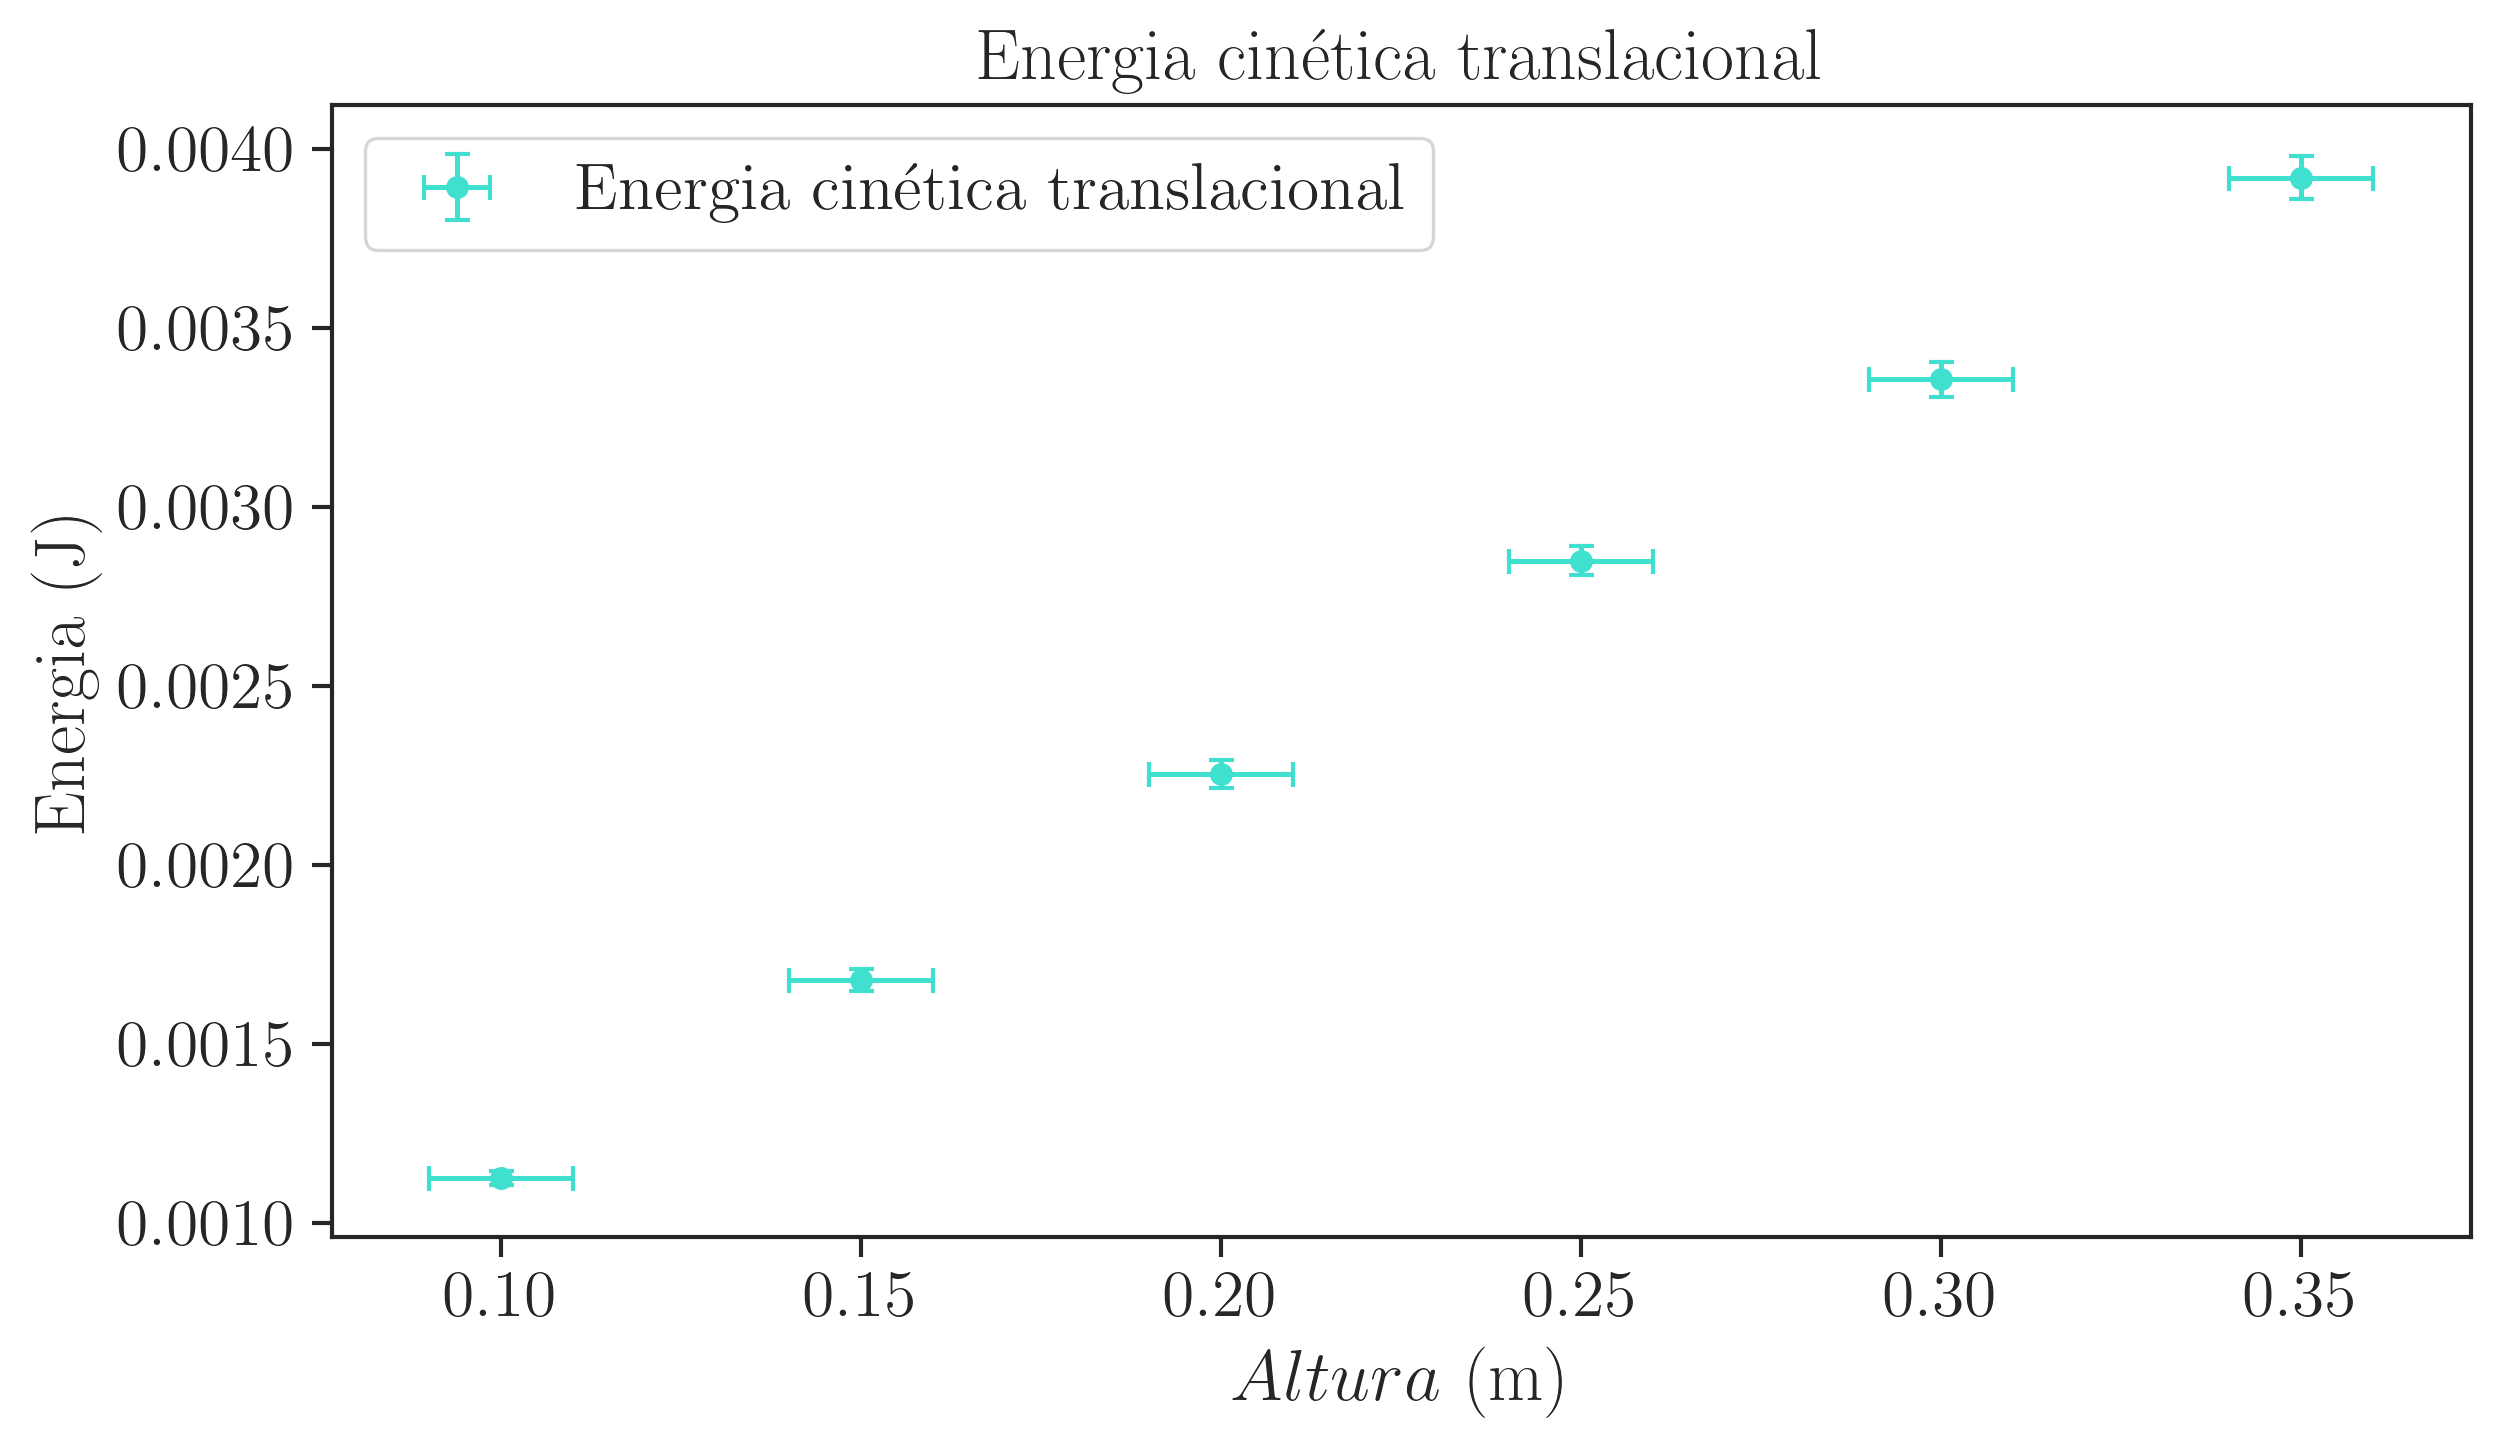

In [16]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
ax = plt.subplot(111)

ax.errorbar(altura, K_T, sigma_K_T, sigma_h, 'o', ms = 4.5, capsize=3, color = 'turquoise',
             label = 'Energia cinética translacional')

plt.xlabel(r"$Altura$ (m)")
plt.ylabel('Energia (J)')
plt.title('Energia cinética translacional')
plt.legend()

plt.savefig('Graphs/RodaMaxwell/EnergiaCT.pdf')
plt.show()

# Gráfico de energia cinética rotacional

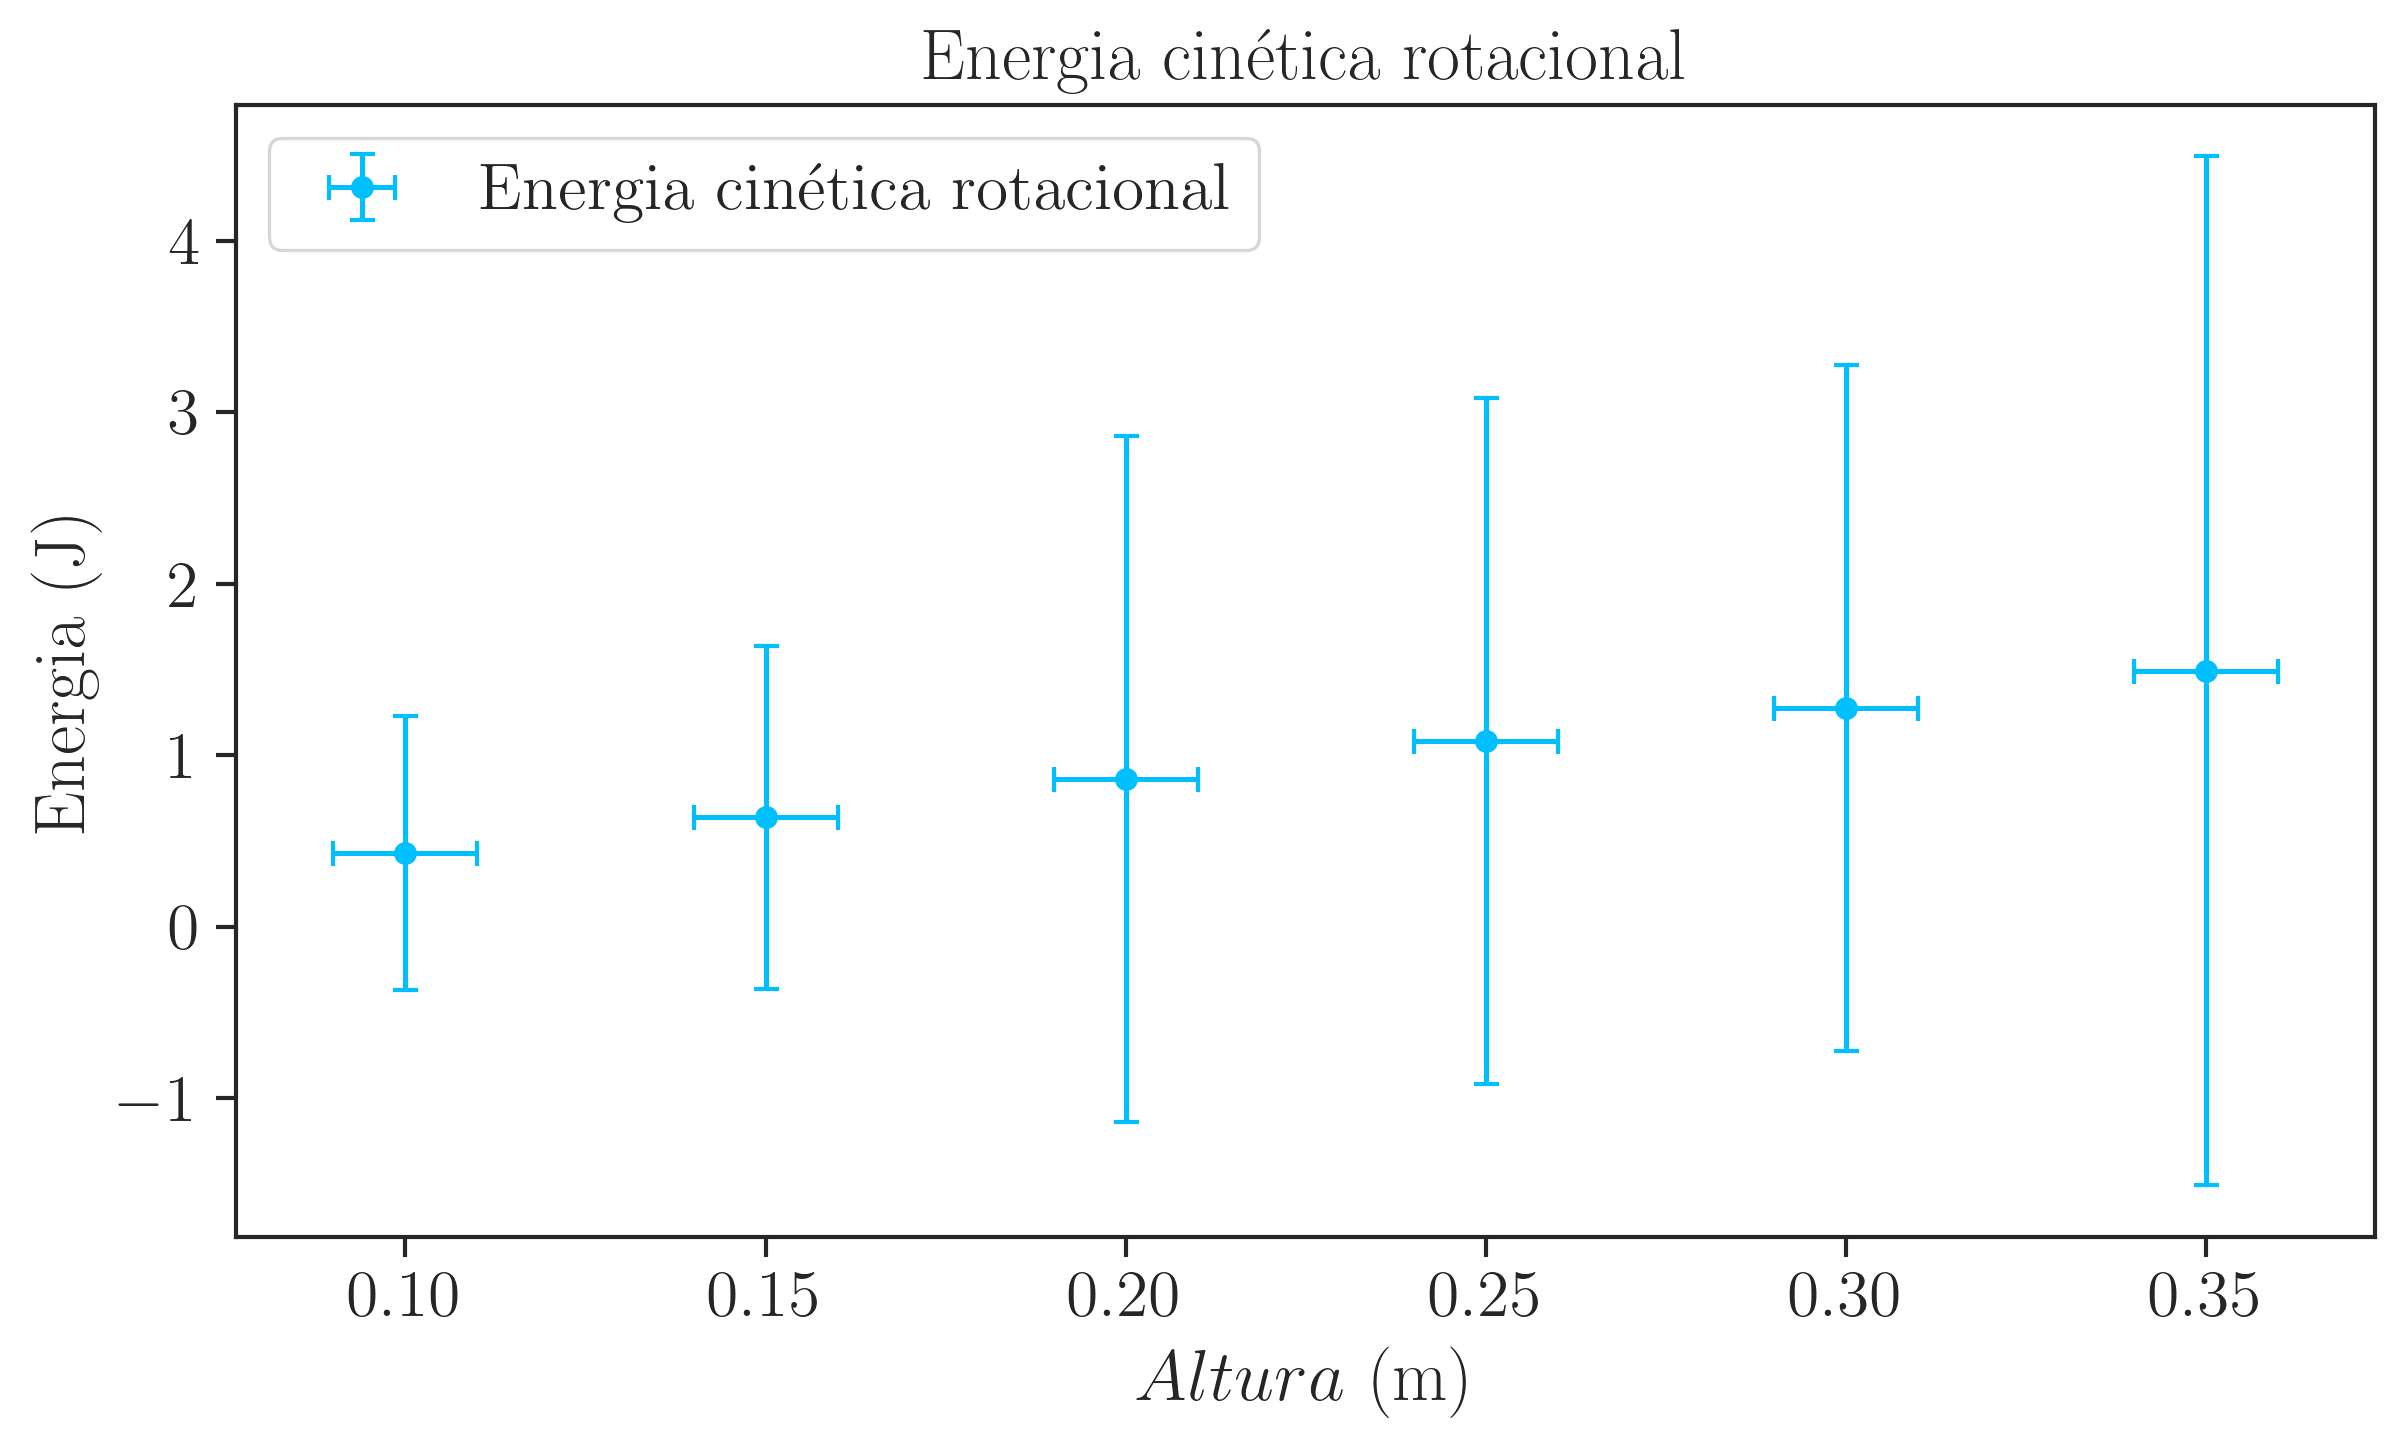

In [17]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
ax = plt.subplot(111)

ax.errorbar(altura, K_R, sigma_K_R, sigma_h, 'o', ms = 4.5, capsize=3, color = 'deepskyblue',
             label = 'Energia cinética rotacional')

plt.xlabel(r"$Altura$ (m)")
plt.ylabel('Energia (J)')
plt.title('Energia cinética rotacional')
plt.legend()

plt.savefig('Graphs/RodaMaxwell/EnergiaCR.pdf')
plt.show()

# Gráfico da energia mecânica total

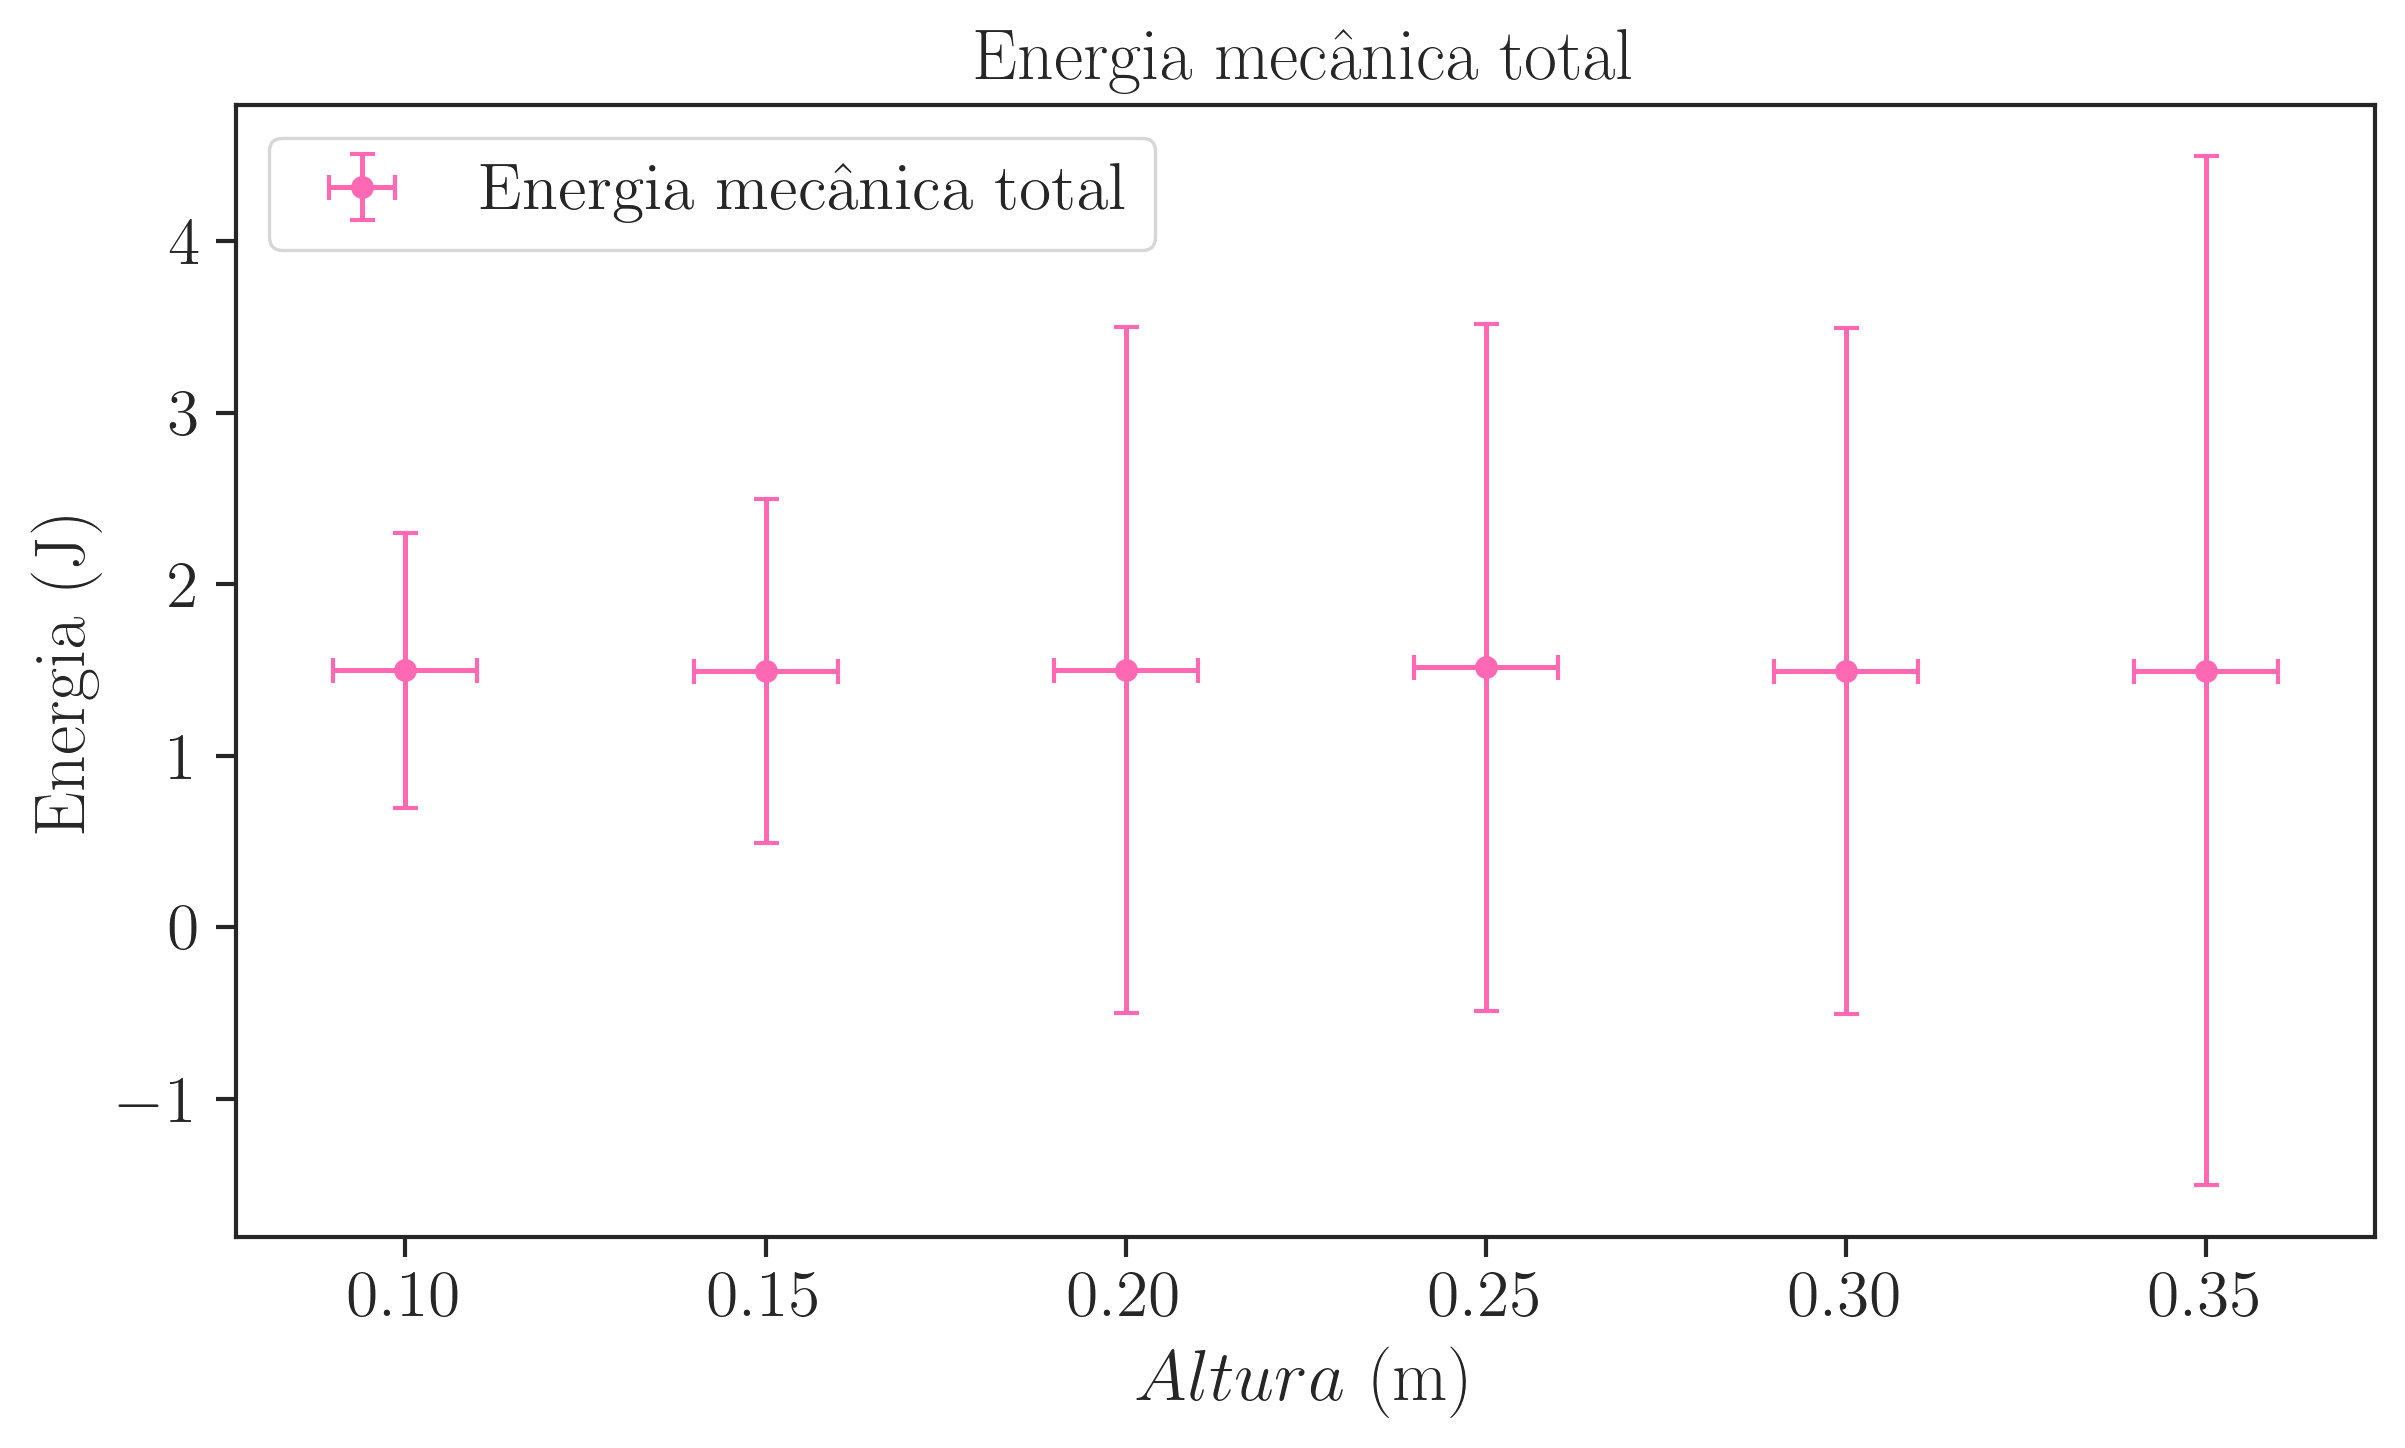

In [18]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
ax = plt.subplot(111)

ax.errorbar(altura, E, sigma_E, sigma_h, 'o', ms = 4.5, capsize=3, color = 'hotpink',
             label = 'Energia mecânica total')

plt.xlabel(r"$Altura$ (m)")
plt.ylabel('Energia (J)')
plt.title('Energia mecânica total')
plt.legend()

plt.savefig('Graphs/RodaMaxwell/EnergiaTotal.pdf')
plt.show()